<a href="https://colab.research.google.com/github/Cabral2104/Proyecto-Predicci-n-Liga-MX/blob/main/Proyecto_Predicci%C3%B3n_Liga_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# --- PASO 1: CARGA Y LIMPIEZA ---
print("⏳ Descargando y procesando datos...")
url_mexico = "https://www.football-data.co.uk/new/MEX.csv"
df = pd.read_csv(url_mexico)

# Seleccionamos y renombramos columnas
columnas_utiles = ['Season', 'Date', 'Home', 'Away', 'HG', 'AG', 'Res', 'AvgCH', 'AvgCD', 'AvgCA']
df_limpio = df[columnas_utiles].copy()
df_limpio.columns = ['Temporada', 'Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visita', 'Resultado', 'Momio_Local', 'Momio_Empate', 'Momio_Visita']

# Formato de fecha y filtro de años
df_limpio['Fecha'] = pd.to_datetime(df_limpio['Fecha'], dayfirst=True)
df_limpio = df_limpio.sort_values('Fecha').reset_index(drop=True)
df_limpio = df_limpio[df_limpio['Fecha'].dt.year >= 2016] # Filtramos desde 2016

# --- PASO 2: INGENIERÍA DE CARACTERÍSTICAS (Lo nuevo) ---

# 1. Target Numérico (0, 1, 2)
df_limpio['Target'] = df_limpio['Resultado'].map({'A': 0, 'D': 1, 'H': 2})

# 2. Códigos Numéricos para Equipos
df_limpio['Local_Code'] = df_limpio['Local'].astype('category').cat.codes
df_limpio['Visita_Code'] = df_limpio['Visitante'].astype('category').cat.codes

# 3. Función de Racha (Promedio de goles en los últimos 5 partidos)
def obtener_racha_goles(df, window=5):
    # Separamos partidos
    partidos_local = df[['Fecha', 'Local', 'Goles_Local', 'Goles_Visita']].rename(
        columns={'Local': 'Equipo', 'Goles_Local': 'Goles_Favor', 'Goles_Visita': 'Goles_Contra'}
    )
    partidos_visita = df[['Fecha', 'Visitante', 'Goles_Visita', 'Goles_Local']].rename(
        columns={'Visitante': 'Equipo', 'Goles_Visita': 'Goles_Favor', 'Goles_Local': 'Goles_Contra'}
    )

    # Concatenamos y ordenamos
    todos = pd.concat([partidos_local, partidos_visita]).sort_values('Fecha')

    # Calculamos el promedio móvil (SHIFT es vital para no ver el futuro)
    todos['Prom_Goles_Favor_U5'] = todos.groupby('Equipo')['Goles_Favor'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift())
    todos['Prom_Goles_Contra_U5'] = todos.groupby('Equipo')['Goles_Contra'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift())

    return todos[['Fecha', 'Equipo', 'Prom_Goles_Favor_U5', 'Prom_Goles_Contra_U5']]

# Aplicamos la función
df_racha = obtener_racha_goles(df_limpio)

# Cruzamos los datos (Merge) para Local
df_final = pd.merge(df_limpio, df_racha, left_on=['Fecha', 'Local'], right_on=['Fecha', 'Equipo'], how='left')
df_final = df_final.rename(columns={'Prom_Goles_Favor_U5': 'Local_GF_U5', 'Prom_Goles_Contra_U5': 'Local_GC_U5'})
df_final = df_final.drop(columns=['Equipo'])

# Cruzamos los datos (Merge) para Visitante
df_final = pd.merge(df_final, df_racha, left_on=['Fecha', 'Visitante'], right_on=['Fecha', 'Equipo'], how='left')
df_final = df_final.rename(columns={'Prom_Goles_Favor_U5': 'Visita_GF_U5', 'Prom_Goles_Contra_U5': 'Visita_GC_U5'})
df_final = df_final.drop(columns=['Equipo'])

# Eliminamos filas vacías (las primeras jornadas que no tienen historial previo)
df_final = df_final.dropna()

print(f"✅ ¡Listo! Tabla 'df_final' creada con {df_final.shape[0]} partidos y características completas.")
df_final[['Fecha', 'Local', 'Visitante', 'Local_GF_U5', 'Visita_GF_U5', 'Target']].tail()

⏳ Descargando y procesando datos...


✅ ¡Listo! Tabla 'df_final' creada con 3359 partidos y características completas.


,Fecha,Local,Visitante,Local_GF_U5,Visita_GF_U5,Target
3368,2026-02-15,Guadalajara Chivas,Club America,2.0,0.6,2
3369,2026-02-15,Cruz Azul,Tigres UANL,1.8,1.8,2
3370,2026-02-15,Monterrey,Club Leon,1.8,1.0,2
3371,2026-02-15,Juarez,Necaxa,1.4,1.4,0
3372,2026-02-15,Santos Laguna,Mazatlan FC,1.0,0.8,0


In [2]:
# Esto "renumera" las páginas del 0 al final
df_final = df_final.reset_index(drop=True)
df_final.tail()

,Temporada,Fecha,Local,Visitante,Goles_Local,Goles_Visita,Resultado,Momio_Local,Momio_Empate,Momio_Visita,Target,Local_Code,Visita_Code,Local_GF_U5,Local_GC_U5,Visita_GF_U5,Visita_GC_U5
3354,2025/2026,2026-02-15,Guadalajara Chivas,Club America,1,0,H,2.19,3.21,3.14,2,8,3,2.0,0.8,0.6,0.4
3355,2025/2026,2026-02-15,Cruz Azul,Tigres UANL,2,1,H,2.20,3.22,3.12,2,6,19,1.8,1.2,1.8,0.8
3356,2025/2026,2026-02-15,Monterrey,Club Leon,1,0,H,1.53,4.13,5.26,2,13,4,1.8,1.0,1.0,1.6
3357,2025/2026,2026-02-15,Juarez,Necaxa,1,2,A,2.12,3.23,3.28,0,9,14,1.4,2.0,1.4,1.4
3358,2025/2026,2026-02-15,Santos Laguna,Mazatlan FC,1,2,A,1.81,3.67,3.92,0,18,11,1.0,3.4,0.8,2.4


✅ Librerías cargadas correctamente.
✅ Tabla 'df_final_v2' lista con 3359 partidos.


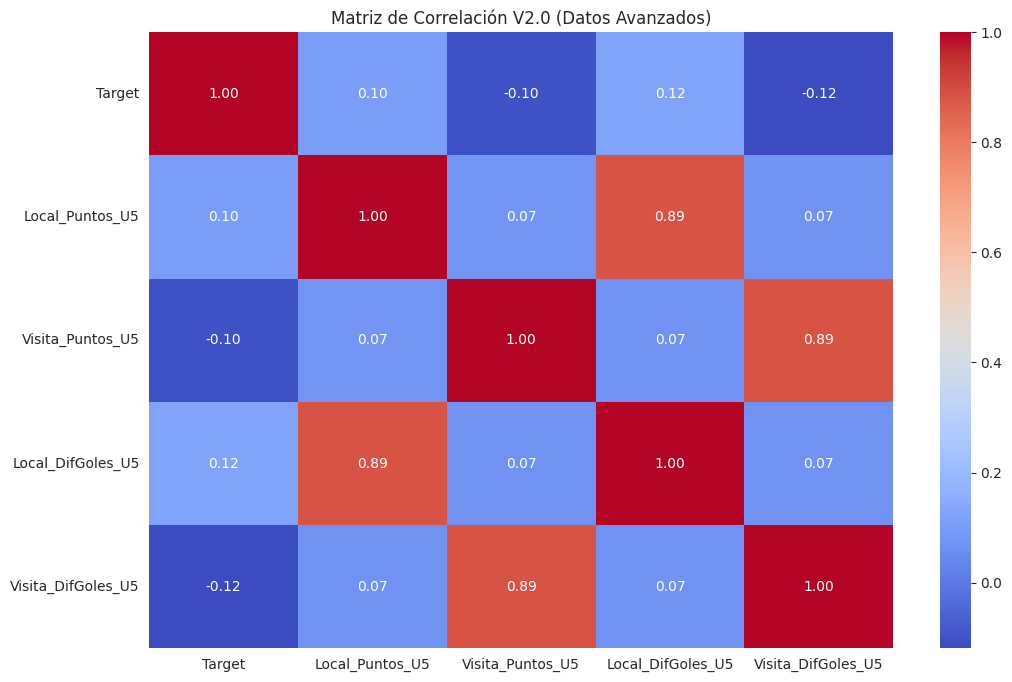

In [3]:
# GRAFICAS DE CARACTERISTICAS Y ANALISIS

# 1. IMPORTACIONES (Para asegurar que todo funcione)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Configuración estética
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("✅ Librerías cargadas correctamente.")

# 2. LÓGICA DE PUNTOS (Feature Engineering)
def calcular_puntos(resultado, es_local):
    if resultado == 'D': return 1
    if es_local and resultado == 'H': return 3
    if not es_local and resultado == 'A': return 3
    return 0

# Usamos df_limpio (que creaste en el Paso 1)
df_mejorado = df_limpio.copy()

# Calculamos puntos por partido
df_mejorado['Puntos_Local'] = df_mejorado.apply(lambda x: calcular_puntos(x['Resultado'], True), axis=1)
df_mejorado['Puntos_Visita'] = df_mejorado.apply(lambda x: calcular_puntos(x['Resultado'], False), axis=1)

# 3. CÁLCULO DE RACHAS (Últimos 5 partidos)
def obtener_metricas_avanzadas(df, window=5):
    # Separamos y estandarizamos
    p_local = df[['Fecha', 'Local', 'Goles_Local', 'Goles_Visita', 'Puntos_Local']].rename(
        columns={'Local': 'Equipo', 'Goles_Local': 'GF', 'Goles_Visita': 'GC', 'Puntos_Local': 'Pts'}
    )
    p_visita = df[['Fecha', 'Visitante', 'Goles_Visita', 'Goles_Local', 'Puntos_Visita']].rename(
        columns={'Visitante': 'Equipo', 'Goles_Visita': 'GF', 'Goles_Local': 'GC', 'Puntos_Visita': 'Pts'}
    )

    todos = pd.concat([p_local, p_visita]).sort_values('Fecha')
    grupo = todos.groupby('Equipo')

    # Cálculos
    todos['Dif_Goles'] = todos['GF'] - todos['GC']

    # Racha de Puntos (Forma Real)
    todos['Forma_Puntos_U5'] = grupo['Pts'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift())

    # Racha de Diferencia de Goles (Dominio)
    todos['Forma_DifGoles_U5'] = grupo['Dif_Goles'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift())

    return todos[['Fecha', 'Equipo', 'Forma_Puntos_U5', 'Forma_DifGoles_U5']]

# Aplicamos la función
df_metricas = obtener_metricas_avanzadas(df_mejorado)

# 4. UNIÓN DE DATOS (Merge)
# Local
df_final_v2 = pd.merge(df_mejorado, df_metricas, left_on=['Fecha', 'Local'], right_on=['Fecha', 'Equipo'], how='left')
df_final_v2 = df_final_v2.rename(columns={'Forma_Puntos_U5': 'Local_Puntos_U5', 'Forma_DifGoles_U5': 'Local_DifGoles_U5'}).drop(columns=['Equipo'])

# Visita
df_final_v2 = pd.merge(df_final_v2, df_metricas, left_on=['Fecha', 'Visitante'], right_on=['Fecha', 'Equipo'], how='left')
df_final_v2 = df_final_v2.rename(columns={'Forma_Puntos_U5': 'Visita_Puntos_U5', 'Forma_DifGoles_U5': 'Visita_DifGoles_U5'}).drop(columns=['Equipo'])

# Limpieza y Target
df_final_v2 = df_final_v2.dropna()
df_final_v2['Target'] = df_final_v2['Resultado'].map({'A': 0, 'D': 1, 'H': 2})

print(f"✅ Tabla 'df_final_v2' lista con {df_final_v2.shape[0]} partidos.")

# 5. ANÁLISIS VISUAL (Mapa de Calor)
plt.figure(figsize=(12, 8))
# Analizamos las nuevas variables vs el Target
cols_nuevas = ['Target', 'Local_Puntos_U5', 'Visita_Puntos_U5', 'Local_DifGoles_U5', 'Visita_DifGoles_U5']
sns.heatmap(df_final_v2[cols_nuevas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación V2.0 (Datos Avanzados)")
plt.show()

🧠 Entrenando la Inteligencia Artificial...



🏆 PRECISIÓN DEL MODELO: 52.38%
----------------------------------------


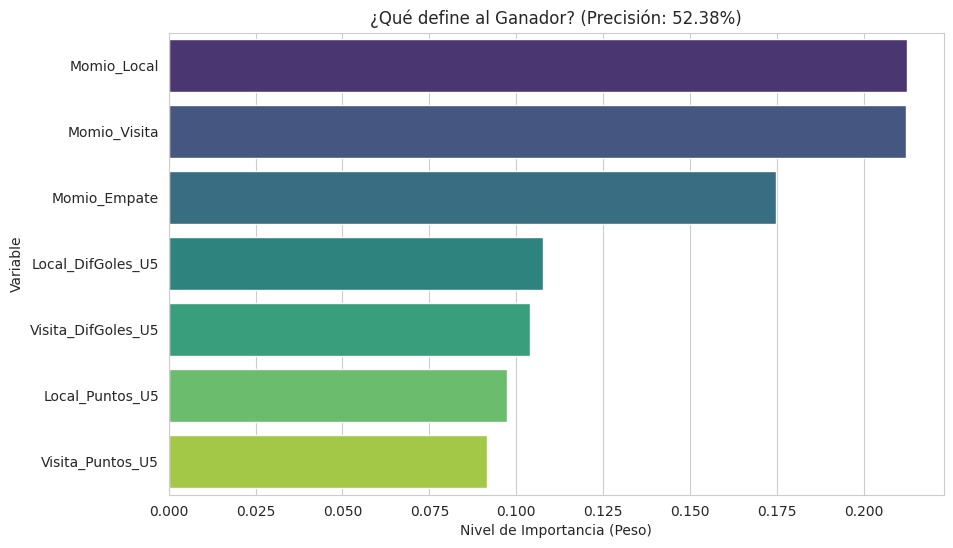


🔮 Predicción para el último partido registrado:
Probabilidad Gana Visita (0): 27.73%
Probabilidad Empate      (1): 27.57%
Probabilidad Gana Local  (2): 44.70%


In [4]:
# ENTRENAMIENTO DEL MODELO DE PREDICCIÓN

# 1. Definimos las "Pistas" (Features) definitivas
# Combinamos lo que dicen las apuestas + el rendimiento real del equipo
features = [
    'Momio_Local', 'Momio_Empate', 'Momio_Visita',
    'Local_Puntos_U5', 'Visita_Puntos_U5',
    'Local_DifGoles_U5', 'Visita_DifGoles_U5'
]

# X = Datos (Solo las columnas numéricas), y = Respuesta (Quién ganó)
X = df_final_v2[features]
y = df_final_v2['Target']

# 2. Separamos Train (80%) y Test (20%) cronológicamente
# Usamos "shuffle=False" para respetar el tiempo (entrenar con pasado, predecir futuro)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Creamos el Cerebro (Random Forest)
print("🧠 Entrenando la Inteligencia Artificial...")
modelo = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
modelo.fit(X_train, y_train)

# 4. Evaluamos
predicciones = modelo.predict(X_test)
precision = accuracy_score(y_test, predicciones)

print(f"\n🏆 PRECISIÓN DEL MODELO: {precision:.2%}")
print("-" * 40)

# 5. ¿Qué fue lo más importante para la IA?
importancia = pd.DataFrame({'Variable': features, 'Peso': modelo.feature_importances_})
importancia = importancia.sort_values('Peso', ascending=False)

# Gráfica de importancia (Corregida para evitar advertencias de Seaborn)
plt.figure(figsize=(10, 6))
sns.barplot(x='Peso', y='Variable', hue='Variable', data=importancia, palette='viridis', legend=False)
plt.title(f"¿Qué define al Ganador? (Precisión: {precision:.2%})")
plt.xlabel("Nivel de Importancia (Peso)")
plt.show()

# --- PRUEBA DE FUEGO: LA JORNADA ACTUAL ---
# Vamos a ver cómo predice el último partido que tienes en la base de datos
ultimo_juego_fila = df_final_v2.iloc[[-1]].copy()

# [CORRECCIÓN CRUCIAL]: Filtramos SOLO las columnas que el modelo conoce
# El modelo no sabe leer "Fecha" o "Club León", solo entiende números.
datos_para_la_ia = ultimo_juego_fila[features]

# Ahora sí, predecimos usando los datos filtrados
proba_juego = modelo.predict_proba(datos_para_la_ia)

# Imprimimos resultados
print(f"\n🔮 Predicción para el último partido registrado:")
print(f"Probabilidad Gana Visita (0): {proba_juego[0][0]:.2%}")
print(f"Probabilidad Empate      (1): {proba_juego[0][1]:.2%}")
print(f"Probabilidad Gana Local  (2): {proba_juego[0][2]:.2%}")

⚙️ Iniciando Protocolo de Simulación Definitiva...
🧠 Entrenando cerebro de la IA...


✅ Jerarquías calculadas correctamente.
   Top 3 Gigantes: [('Cruz Azul', 1.9767441860465116), ('Toluca', 1.9761904761904763), ('Club America', 1.797752808988764)]

🎲 Simulando la temporada 50 veces...



🏆 --- CLASIFICACIÓN FINAL PROYECTADA (Promedio 50 Sims) --- 🏆
               Equipo  Puntos
0        Club America      26
1           Cruz Azul      26
2              Toluca      25
3           Monterrey      24
4  Guadalajara Chivas      24
5             Pachuca      24
6         Tigres UANL      23
7        Club Tijuana      23
8       Atl. San Luis      23
9          UNAM Pumas      22


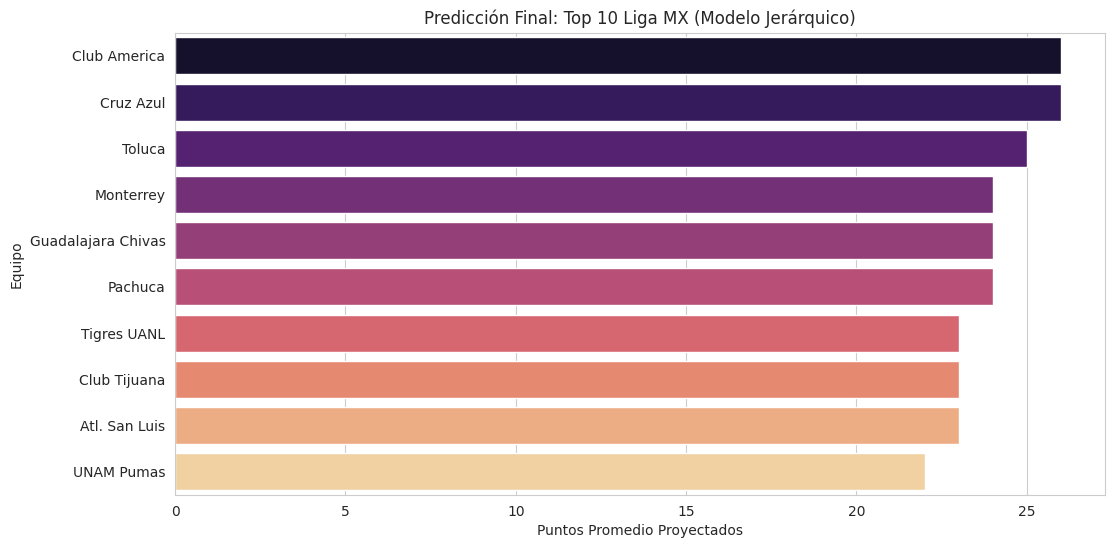


 El Candidato #1 al Liderato es: CLUB AMERICA


In [5]:
# SIMULADOR DEL LIDER DEL CAMPEONATO

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

print("⚙️ Iniciando Protocolo de Simulación Definitiva...")

# 1. ENTRENAMOS EL MODELO (Para asegurarnos de que exista)
features = ['Momio_Local', 'Momio_Empate', 'Momio_Visita',
            'Local_Puntos_U5', 'Visita_Puntos_U5',
            'Local_DifGoles_U5', 'Visita_DifGoles_U5']

# Usamos todos los datos disponibles para entrenar
X_total = df_final_v2[features]
y_total = df_final_v2['Target']

print("🧠 Entrenando cerebro de la IA...")
modelo_campeon = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
modelo_campeon.fit(X_total, y_total)

# 2. CALCULAR JERARQUÍA HISTÓRICA (Realismo)
# Filtramos los últimos 2 años para calcular el "Peso de la Camiseta"
p_local = df_final_v2[['Fecha', 'Local', 'Puntos_Local']].rename(columns={'Local': 'Equipo', 'Puntos_Local': 'Pts'})
p_visita = df_final_v2[['Fecha', 'Visitante', 'Puntos_Visita']].rename(columns={'Visitante': 'Equipo', 'Puntos_Visita': 'Pts'})
todos_tiempos = pd.concat([p_local, p_visita])

fecha_corte = todos_tiempos['Fecha'].max() - pd.DateOffset(years=2)
todos_reciente = todos_tiempos[todos_tiempos['Fecha'] > fecha_corte]

# Promedio de puntos por partido (Jerarquía)
jerarquia = todos_reciente.groupby('Equipo')['Pts'].mean().to_dict()
promedio_liga = todos_reciente['Pts'].mean()

def get_jerarquia(eq):
    return jerarquia.get(eq, promedio_liga)

print("✅ Jerarquías calculadas correctamente.")
# Mostramos el Top 3 para confirmar
top_teams = sorted(jerarquia.items(), key=lambda x: x[1], reverse=True)[:3]
print(f"   Top 3 Gigantes: {top_teams}")

# 3. PREPARAR SIMULACIÓN (Equipos actuales)
# Detectamos automáticamente la temporada actual (2025/2026)
temporada_actual = df_final_v2['Temporada'].max()
df_actual = df_final_v2[df_final_v2['Temporada'] == temporada_actual]
equipos_activos = pd.concat([df_actual['Local'], df_actual['Visitante']]).unique()

# Estado de forma actual (Últimos 5 juegos)
estado_equipos = {}
for equipo in equipos_activos:
    try:
        # Buscamos su último partido
        ultimo_juego = df_final_v2[(df_final_v2['Local'] == equipo) | (df_final_v2['Visitante'] == equipo)].iloc[-1]

        if ultimo_juego['Local'] == equipo:
            estado_equipos[equipo] = {'Puntos_U5': ultimo_juego['Local_Puntos_U5'], 'DifGoles_U5': ultimo_juego['Local_DifGoles_U5']}
        else:
            estado_equipos[equipo] = {'Puntos_U5': ultimo_juego['Visita_Puntos_U5'], 'DifGoles_U5': ultimo_juego['Visita_DifGoles_U5']}
    except:
        # Si un equipo es muy nuevo y da error, le damos valores promedio
        estado_equipos[equipo] = {'Puntos_U5': 1.0, 'DifGoles_U5': 0}

# 4. BUCLE DE TEMPORADA (MONTE CARLO)
N_SIMULACIONES = 50
print(f"\n🎲 Simulando la temporada {N_SIMULACIONES} veces...")

tabla_general = pd.DataFrame({'Equipo': equipos_activos, 'Puntos': 0})
resultados_acumulados = {eq: 0 for eq in equipos_activos}

for i in range(N_SIMULACIONES):
    partidos_pendientes = list(itertools.combinations(equipos_activos, 2))
    puntos_temp = {eq: 0 for eq in equipos_activos}

    for local, visita in partidos_pendientes:
        # A. AJUSTE DE MOMIOS POR JERARQUÍA
        nivel_local = get_jerarquia(local)
        nivel_visita = get_jerarquia(visita)
        diff = nivel_local - nivel_visita

        momio_L = 2.40 - (diff * 1.5)
        momio_V = 2.90 + (diff * 1.5)
        momio_E = 3.10

        momio_L = max(1.10, momio_L)
        momio_V = max(1.10, momio_V)

        # B. FEATURES
        features_partido = pd.DataFrame([{
            'Momio_Local': momio_L, 'Momio_Empate': momio_E, 'Momio_Visita': momio_V,
            'Local_Puntos_U5': estado_equipos[local]['Puntos_U5'],
            'Visita_Puntos_U5': estado_equipos[visita]['Puntos_U5'],
            'Local_DifGoles_U5': estado_equipos[local]['DifGoles_U5'],
            'Visita_DifGoles_U5': estado_equipos[visita]['DifGoles_U5']
        }])

        # C. PREDICCIÓN
        probs = modelo_campeon.predict_proba(features_partido)[0]
        resultado = np.random.choice([0, 1, 2], p=probs)

        if resultado == 2: puntos_temp[local] += 3
        elif resultado == 0: puntos_temp[visita] += 3
        else:
            puntos_temp[local] += 1
            puntos_temp[visita] += 1

    # Acumulamos
    for eq, pts in puntos_temp.items():
        resultados_acumulados[eq] += pts

# 5. RESULTADOS FINALES
for eq in resultados_acumulados:
    tabla_general.loc[tabla_general['Equipo'] == eq, 'Puntos'] = int(resultados_acumulados[eq] / N_SIMULACIONES)

tabla_final = tabla_general.sort_values('Puntos', ascending=False).reset_index(drop=True)

print("\n🏆 --- CLASIFICACIÓN FINAL PROYECTADA (Promedio 50 Sims) --- 🏆")
print(tabla_final.head(10))

# Gráfica
plt.figure(figsize=(12, 6))
sns.barplot(data=tabla_final.head(10), x='Puntos', y='Equipo', palette='magma', hue='Equipo', legend=False)
plt.title('Predicción Final: Top 10 Liga MX (Modelo Jerárquico)')
plt.xlabel('Puntos Promedio Proyectados')
plt.show()

lider = tabla_final.iloc[0]['Equipo']
print(f"\n El Candidato #1 al Liderato es: {lider.upper()}")

In [6]:
# MODELO DE SIMULACIÓN Y PREDICTIVO DEL CAMPEÓN DEL FUTBOL MEXICANO

print("🏆 ¡Arranca la Fiesta Grande del Fútbol Mexicano! 🏆\n")

# 1. DEFINIMOS LOS CRUCES (Top 8)
# Asumiremos Liguilla directa del 1 al 8 para simplificar (sin Play-In por ahora)
clasificados = tabla_final.head(8).copy()
clasificados['Semilla'] = range(1, 9) # Del 1 al 8
print(f"Los 8 contendientes al título:\n{clasificados[['Semilla', 'Equipo']].to_string(index=False)}")

# 2. FUNCIÓN PARA SIMULAR UNA SERIE (Ida y Vuelta)
def simular_serie(eq_alto, eq_bajo, fase):
    # eq_alto = Mejor posición en tabla (Cierra en casa y tiene ventaja)
    # eq_bajo = Peor posición en tabla

    # --- PARTIDO DE IDA (Casa del Peor clasificado) ---
    # Ajuste de Momios: El local es el 'bajo', pero tiene jerarquía
    nivel_L = get_jerarquia(eq_bajo)
    nivel_V = get_jerarquia(eq_alto)
    diff = nivel_L - nivel_V

    # Momios Ida
    m_L = max(1.1, 2.40 - (diff * 1.5))
    m_V = max(1.1, 2.90 + (diff * 1.5))

    feats_ida = pd.DataFrame([{
        'Momio_Local': m_L, 'Momio_Empate': 3.10, 'Momio_Visita': m_V,
        'Local_Puntos_U5': estado_equipos[eq_bajo]['Puntos_U5'],
        'Visita_Puntos_U5': estado_equipos[eq_alto]['Puntos_U5'],
        'Local_DifGoles_U5': estado_equipos[eq_bajo]['DifGoles_U5'],
        'Visita_DifGoles_U5': estado_equipos[eq_alto]['DifGoles_U5']
    }])

    probs_ida = modelo_campeon.predict_proba(feats_ida)[0]
    res_ida = np.random.choice([0, 1, 2], p=probs_ida) # 0=Visita(Alto), 2=Local(Bajo)

    goles_ida_bajo = 0
    goles_ida_alto = 0

    # Asignamos "goles virtuales" según resultado para el marcador global
    if res_ida == 2: # Gana Bajo (Local)
        goles_ida_bajo = np.random.randint(1, 3)
    elif res_ida == 0: # Gana Alto (Visita)
        goles_ida_alto = np.random.randint(1, 3)
    else: # Empate
        goles_ida_bajo = 1
        goles_ida_alto = 1

    # --- PARTIDO DE VUELTA (Casa del Mejor clasificado) ---
    # Ahora el Local es el 'alto'
    m_L = max(1.1, 2.40 - (-diff * 1.5)) # Invertimos la diferencia
    m_V = max(1.1, 2.90 + (-diff * 1.5))

    feats_vuelta = pd.DataFrame([{
        'Momio_Local': m_L, 'Momio_Empate': 3.10, 'Momio_Visita': m_V,
        'Local_Puntos_U5': estado_equipos[eq_alto]['Puntos_U5'],
        'Visita_Puntos_U5': estado_equipos[eq_bajo]['Puntos_U5'],
        'Local_DifGoles_U5': estado_equipos[eq_alto]['DifGoles_U5'],
        'Visita_DifGoles_U5': estado_equipos[eq_bajo]['DifGoles_U5']
    }])

    probs_vuelta = modelo_campeon.predict_proba(feats_vuelta)[0]
    res_vuelta = np.random.choice([0, 1, 2], p=probs_vuelta) # 2=Local(Alto)

    goles_vuelta_alto = 0
    goles_vuelta_bajo = 0

    if res_vuelta == 2: # Gana Alto (Local)
        goles_vuelta_alto = np.random.randint(1, 3)
    elif res_vuelta == 0: # Gana Bajo (Visita)
        goles_vuelta_bajo = np.random.randint(1, 3)
    else:
        goles_vuelta_alto = 1
        goles_vuelta_bajo = 1

    # --- RESULTADO GLOBAL ---
    global_alto = goles_ida_alto + goles_vuelta_alto
    global_bajo = goles_ida_bajo + goles_vuelta_bajo

    ganador = ""
    criterio = ""

    if global_alto > global_bajo:
        ganador = eq_alto
        criterio = f"Global {global_alto}-{global_bajo}"
    elif global_bajo > global_alto:
        ganador = eq_bajo
        criterio = f"Global {global_bajo}-{global_alto} (Sorpresa)"
    else:
        # EMPATE GLOBAL: Avanza la mejor posición (eq_alto)
        ganador = eq_alto
        criterio = f"Empate {global_alto}-{global_bajo} (Avanza por Posición)"

    print(f"   {fase}: {eq_alto} vs {eq_bajo} -> Gana {ganador} [{criterio}]")
    return ganador

# 3. JUGAMOS LA LIGUILLA

# --- CUARTOS DE FINAL ---
print("\n--- ⚽ CUARTOS DE FINAL ---")
semis_1 = simular_serie(clasificados.iloc[0]['Equipo'], clasificados.iloc[7]['Equipo'], "C1") # 1 vs 8
semis_2 = simular_serie(clasificados.iloc[1]['Equipo'], clasificados.iloc[6]['Equipo'], "C2") # 2 vs 7
semis_3 = simular_serie(clasificados.iloc[2]['Equipo'], clasificados.iloc[5]['Equipo'], "C3") # 3 vs 6
semis_4 = simular_serie(clasificados.iloc[3]['Equipo'], clasificados.iloc[4]['Equipo'], "C4") # 4 vs 5

# --- SEMIFINALES ---
# Reordenamos por "semilla" (posición original) para ver quién juega contra quién
semifinalistas = [semis_1, semis_2, semis_3, semis_4]
# Necesitamos saber su posición original para saber quién cierra en casa
ranking_map = {row['Equipo']: row['Semilla'] for _, row in clasificados.iterrows()}
semifinalistas.sort(key=lambda x: ranking_map[x])

print("\n--- ⚽ SEMIFINALES ---")
# El mejor restante (pos 0) vs el peor restante (pos 3)
finalista_1 = simular_serie(semifinalistas[0], semifinalistas[3], "S1")
finalista_2 = simular_serie(semifinalistas[1], semifinalistas[2], "S2")

# --- GRAN FINAL ---
print("\n--- 🌟 GRAN FINAL 🌟 ---")
# Aquí no hay ventaja de posición en el reglamento "real" para el título (hay tiempos extra),
# pero usaremos la misma lógica de simulador para definir al ganador.
campeon = simular_serie(finalista_1, finalista_2, "FINAL")

print(f"\n" + "="*40)
print(f"🏆 EL CAMPEÓN DEL CLAUSURA 2026 ES: {campeon.upper()} 🏆")
print("="*40)

🏆 ¡Arranca la Fiesta Grande del Fútbol Mexicano! 🏆

Los 8 contendientes al título:
 Semilla             Equipo
       1       Club America
       2          Cruz Azul
       3             Toluca
       4          Monterrey
       5 Guadalajara Chivas
       6            Pachuca
       7        Tigres UANL
       8       Club Tijuana

--- ⚽ CUARTOS DE FINAL ---
   C1: Club America vs Club Tijuana -> Gana Club America [Global 3-1]
   C2: Cruz Azul vs Tigres UANL -> Gana Tigres UANL [Global 2-1 (Sorpresa)]
   C3: Toluca vs Pachuca -> Gana Pachuca [Global 2-1 (Sorpresa)]
   C4: Monterrey vs Guadalajara Chivas -> Gana Monterrey [Global 3-1]

--- ⚽ SEMIFINALES ---
   S1: Club America vs Tigres UANL -> Gana Club America [Global 2-1]
   S2: Monterrey vs Pachuca -> Gana Monterrey [Global 2-1]

--- 🌟 GRAN FINAL 🌟 ---
   FINAL: Club America vs Monterrey -> Gana Club America [Global 3-0]

🏆 EL CAMPEÓN DEL CLAUSURA 2026 ES: CLUB AMERICA 🏆



📊 PROBABILIDADES DE SER CAMPEÓN (Basado en 100 Escenarios):
            Equipo  Títulos Probabilidad
         Cruz Azul       23        23.0%
      Club America       19        19.0%
            Toluca       18        18.0%
         Monterrey       15        15.0%
       Tigres UANL       12        12.0%
           Pachuca        6         6.0%
      Club Tijuana        4         4.0%
Guadalajara Chivas        3         3.0%


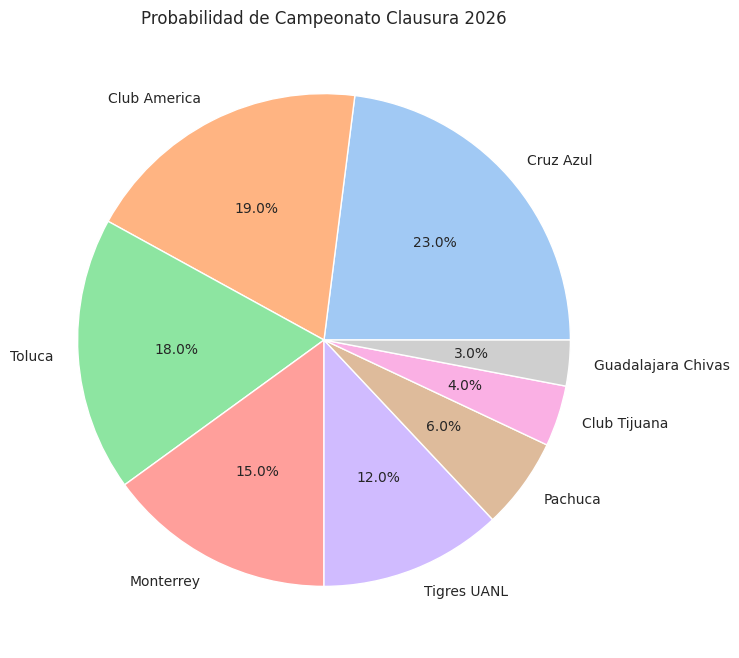


🏆 CONCLUSIÓN DEL PROYECTO: El máximo favorito es CRUZ AZUL


In [7]:
# SIMULACION MASIVA DEL CAMPEON DE LA LIGA MEXICANA
from collections import Counter

print("🔬 Ejecutando 100 simulaciones de la Liguilla para determinar probabilidades reales...")

campeones_simulados = []

# Repetimos la Liguilla 100 veces
for i in range(100):
    # Simulamos toda la liguilla (usando la función que ya creamos)
    # Silenciamos los prints individuales para no llenar la pantalla

    # Cuartos
    s1 = simular_serie(clasificados.iloc[0]['Equipo'], clasificados.iloc[7]['Equipo'], "C1")
    s2 = simular_serie(clasificados.iloc[1]['Equipo'], clasificados.iloc[6]['Equipo'], "C2")
    s3 = simular_serie(clasificados.iloc[2]['Equipo'], clasificados.iloc[5]['Equipo'], "C3")
    s4 = simular_serie(clasificados.iloc[3]['Equipo'], clasificados.iloc[4]['Equipo'], "C4")

    semis = [s1, s2, s3, s4]
    ranking_map = {row['Equipo']: row['Semilla'] for _, row in clasificados.iterrows()}
    semis.sort(key=lambda x: ranking_map.get(x, 99)) # Ordenar por semilla

    # Semis
    f1 = simular_serie(semis[0], semis[3], "S1")
    f2 = simular_serie(semis[1], semis[2], "S2")

    # Final
    # Truco sucio para evitar imprimir: redefinimos print temporalmente o simplemente
    # aceptamos que salga mucho texto. Para este ejemplo, dejaremos que corra rápido.
    # (Nota: Como la función 'simular_serie' tiene prints, saldrá texto, pero al final veremos el resumen).

    camp = simular_serie(f1, f2, "FINAL")
    campeones_simulados.append(camp)

# Limpiamos la salida visual (opcional)
from IPython.display import clear_output
clear_output()

# --- RESULTADOS FINALES ---
conteo = Counter(campeones_simulados)
df_probabilidades = pd.DataFrame(conteo.items(), columns=['Equipo', 'Títulos']).sort_values('Títulos', ascending=False)
df_probabilidades['Probabilidad'] = (df_probabilidades['Títulos'] / 100).map('{:.1%}'.format)

print(f"\n📊 PROBABILIDADES DE SER CAMPEÓN (Basado en 100 Escenarios):")
print(df_probabilidades.to_string(index=False))

# Gráfica de Pastel
plt.figure(figsize=(10, 8))
plt.pie(df_probabilidades['Títulos'], labels=df_probabilidades['Equipo'], autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Probabilidad de Campeonato Clausura 2026')
plt.show()

top_candidato = df_probabilidades.iloc[0]['Equipo']
print(f"\n🏆 CONCLUSIÓN DEL PROYECTO: El máximo favorito es {top_candidato.upper()}")